In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
cd /kaggle/input/dataset

/kaggle/input/dataset


Dataset Creation

In [ ]:
#dataset merging for the three small datasets

df = pd.DataFrame(columns=['Text','Language'])
for filename in os.listdir('datasets'):
    f = os.path.join('datasets', filename)
    if 'csv' in filename:
       if 'sentences' not in filename:
            df1 = pd.read_csv(f)
            if 'language' in df1.columns:
                df1=df1.rename(columns={'language':'Language'})
            df = pd.concat([df,df1],axis=0)   

In [ ]:
sizes = dict()
for lang in df['Language'].unique():
    temp = df[df['Language']== lang]
    sizes[lang] = temp.shape[0]

In [ ]:
#loading the big dataset
temp = pd.read_csv('/Users/yashashvini/Desktop/MSU/CSE842/project/datasets/sentences.csv')

In [ ]:
#loading the abbreviations for the languages 
import json
with open('/Users/yashashvini/Desktop/MSU/CSE842/project/datasets/lan_to_language.json', 'r') as f:
  js_file = json.load(f)

In [ ]:
#  list of the common languages
js_ls = []
count = 0
s = []
for lang in sizes.keys():
    if lang in js_file.values():
        count = count + 1
        js_ls.append(lang)
        s.append(sizes[lang])

In [ ]:
def get_key(val):
    for key, value in js_file.items():
        if val == value:
            return key

In [ ]:
new_s = dict()
for i in js_ls:
    new_s[i] = temp[temp['lan_code']==get_key(i)].shape[0]

In [ ]:
f =dict()
for i in new_s.keys():
    if i in sizes.keys():
        t = new_s[i] + sizes[i]

    if t > 10000:
        f[i] = t


In [ ]:
df = df.rename(columns={'Text':'sentence'})

In [ ]:
l=[]
for lan in f.keys():
    temp1 = df[df['Language']==lan]['sentence']
    temp2 = temp[temp['lan_code']==get_key(lan)]['sentence']
    final = pd.DataFrame(columns=['sentence','language'])
    final['sentence'] = pd.concat([temp1,temp2])
    final = final.assign(language=lan)
    final = final.reset_index(drop=True)
    l.append(final)

In [ ]:
import random
final_data = pd.DataFrame(columns=['sentence','language'])
for i in range(len(l)):
    n = random.randrange(10000,14000)
    t = l[i].sample(n=n,replace=False)
    final_data = pd.concat([final_data,t])

In [ ]:
from sklearn.utils import shuffle
final_data = shuffle(final_data)
final_data = final_data.reset_index(drop=True)

Visualizations

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=30)
sns.set(rc={'figure.figsize':(100,40)})
sns.set(font_scale=5)
sns.countplot(final_data.language)
#plt.tight_layout()


In [ ]:
sizes = []
for lang in final_data['language'].unique():
    temp = final_data[final_data['language']== lang]
    sizes.append(temp.shape[0])

sns.set(font_scale=30)
sns.set(rc={'figure.figsize':(10,5)})
plt.boxplot(sizes)

In [ ]:
final_data.to_csv('Mixed_data.csv')

In [ ]:
!pip install nltk


In [3]:
import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

Sentiment Analysis

In [ ]:
from textblob import TextBlob
def sentiment(txt):
    blob = TextBlob(txt)   
    sentiment = blob.sentiment
    if sentiment.polarity < 0:
        return 'Negative'
    elif sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Positve'
    
final_data.sentiment_score = final_data.sentence.apply(sentiment)

In [ ]:
# to check if the text sentences are neutral.
sns.set(font_scale=4)
sns.set(rc={'figure.figsize':(10,4)})
sns.countplot(final_data.sentiment_score)
#plt.tight_layout()

Word Clouds

In [ ]:
!pip install wordcloud

In [4]:
import nltk
nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [5]:
final_data = pd.read_csv('Mixed_data.csv')
final_data = final_data.drop('Unnamed: 0',axis=1)

In [6]:
final_data.language = final_data.language.apply(str.lower)

In [7]:
l = []
for i in final_data.language.unique():
    if i in stopwords.fileids():
        l.append(i)

In [14]:
def text_creation(final_data,t_lan):
    w1 = final_data[final_data['language']==t_lan]
    w1_txt = ' '.join(txt for txt in w1.sentence)
    return w1_txt

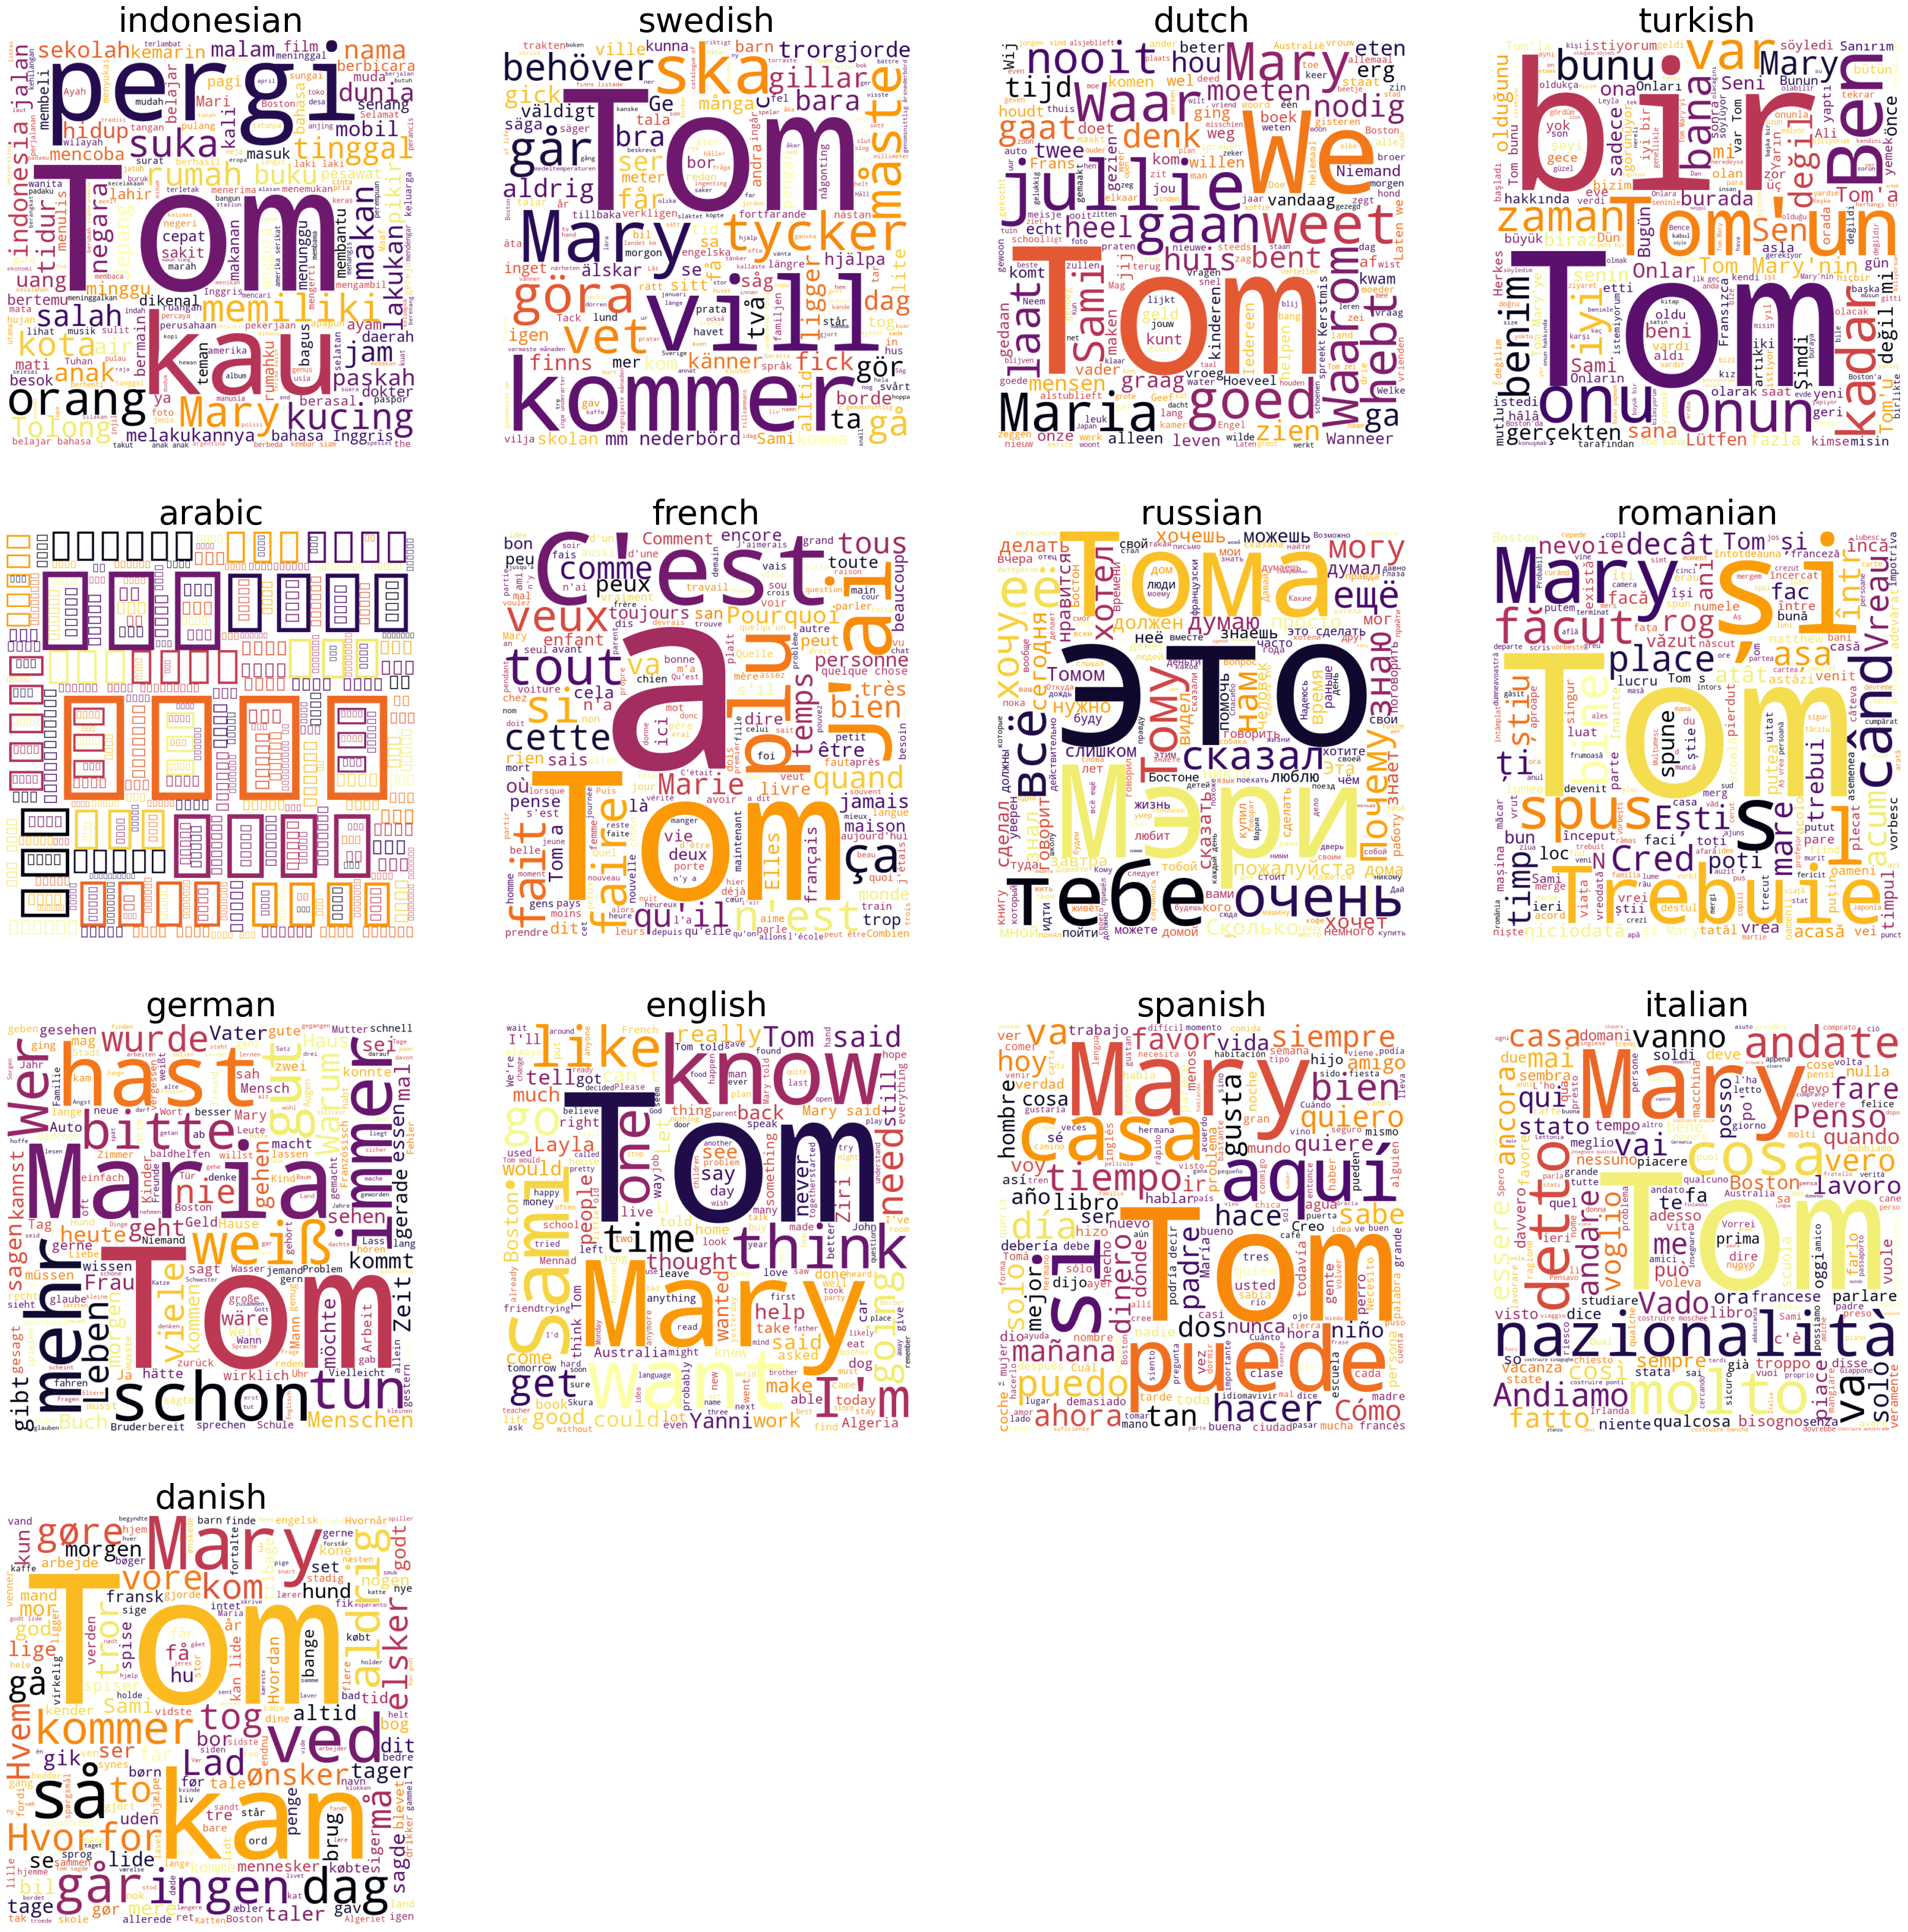

In [15]:
c = 0
fig, axs = plt.subplots(4, 4,figsize=(40,40))
for i in range(4):
    for j in range(4):
        if c < 13:
            t_lan = l[c]
            w1_txt = text_creation(final_data,t_lan)
            c = c + 1
            if t_lan in stopwords.fileids():
                stops = list(stopwords.words(t_lan))
                wordcloud = WordCloud(stopwords=stops,width=800,height=800,background_color='white',colormap="inferno").generate(w1_txt)
                axs[i][j].imshow(wordcloud,interpolation='bilinear')
                axs[i][j].set_title(t_lan, fontsize=40)
                axs[i][j].axis('off')
                
        else:
            axs[i][j].remove()
            axs[i][j].axis('off')

plt.show()

PreProcessing

In [7]:
#since the stopewords are depended and even some charcters are language depended we are planning to do preprocessing based on the lanaguage
from nltk.stem import SnowballStemmer

def get_keywords(row):   
      lang = row['language']
      row = row['sentence']
      row = row.lower()
      row = re.sub('','',row)          
      row = re.sub('https://.*','',row)  
      row = re.sub(r'\d+', '', row)
      tokens = row.split()
      tokens = [x for x in tokens if '@' not in x]
      re_punc = re.compile('[%s]' % re.escape(string.punctuation))
      tokens = [re_punc.sub('', w) for w in tokens]
      if lang in stopwords.fileids():
            stop_words = set(stopwords.words(lang))
            tokens = [w for w in tokens if w not in stop_words]
      else:
            tokens = tokens
      if lang in SnowballStemmer.languages:
            porter = SnowballStemmer(lang)
            stemmed = [porter.stem(word) for word in tokens]
      else:
            tokens = tokens
      tokens = [word for word in tokens if len(word) > 0]
      if tokens == []:
            tokens = np.nan
      return tokens

In [8]:
import re
import string
final_data['Tokens']= final_data.apply(get_keywords,axis=1)

In [9]:
def mix(row):
    return ' '.join(row)

In [10]:
final_data = final_data.dropna()
final_data.Tokens =  final_data.Tokens.apply(mix)

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
import nltk
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

ML MODELS

In [6]:


char_pipeline = Pipeline([
    ('vect_char', CountVectorizer(analyzer='char', ngram_range=(2, 6))),
    ('tfidf_char', TfidfTransformer())
])


word_pipeline = Pipeline([
    ('vect_word', CountVectorizer(analyzer='word', ngram_range=(1, 3))),
    ('tfidf_word', TfidfTransformer())
])


pos_pipeline = Pipeline([
    ('pos', CountVectorizer(tokenizer=nltk.word_tokenize))
])


NB = Pipeline([
    ('features', FeatureUnion([
        ('char_pipeline', char_pipeline),
        ('word_pipeline', word_pipeline),
        ('pos_pipeline', pos_pipeline)
    ])),
    ('clf', MultinomialNB())
])

LC = Pipeline([
    ('features', FeatureUnion([
        ('char_pipeline', char_pipeline),
        ('word_pipeline', word_pipeline),
        ('pos_pipeline', pos_pipeline)
    ])),
    ('LC', linear_model.LogisticRegression(multi_class='ovr', solver='liblinear'))
])

RF = Pipeline([
    ('features', FeatureUnion([
        ('char_pipeline', char_pipeline),
        ('word_pipeline', word_pipeline),
        ('pos_pipeline', pos_pipeline)
    ])),
    ('RF', RandomForestClassifier(max_depth=10, random_state=0))
])


In [7]:
NB

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('char_pipeline',
                                                 Pipeline(steps=[('vect_char',
                                                                  CountVectorizer(analyzer='char',
                                                                                  ngram_range=(2,
                                                                                               6))),
                                                                 ('tfidf_char',
                                                                  TfidfTransformer())])),
                                                ('word_pipeline',
                                                 Pipeline(steps=[('vect_word',
                                                                  CountVectorizer(ngram_range=(1,
                                                                                               3))),
              

In [8]:
LC

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('char_pipeline',
                                                 Pipeline(steps=[('vect_char',
                                                                  CountVectorizer(analyzer='char',
                                                                                  ngram_range=(2,
                                                                                               6))),
                                                                 ('tfidf_char',
                                                                  TfidfTransformer())])),
                                                ('word_pipeline',
                                                 Pipeline(steps=[('vect_word',
                                                                  CountVectorizer(ngram_range=(1,
                                                                                               3))),
              

In [9]:
RF

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('char_pipeline',
                                                 Pipeline(steps=[('vect_char',
                                                                  CountVectorizer(analyzer='char',
                                                                                  ngram_range=(2,
                                                                                               6))),
                                                                 ('tfidf_char',
                                                                  TfidfTransformer())])),
                                                ('word_pipeline',
                                                 Pipeline(steps=[('vect_word',
                                                                  CountVectorizer(ngram_range=(1,
                                                                                               3))),
              

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(final_data['Tokens'],final_data['language'],test_size=0.2)

In [17]:
NB = NB.fit(X_train,y_train)
LC = LC.fit(X_train,y_train)

In [19]:
y_pred = NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))


Accuracy: 0.977663407102419


In [18]:
y_pred = LC.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9733144621718991


In [12]:
from sklearn.ensemble import VotingClassifier
ENS = VotingClassifier(estimators=[('lr',LC),('nb',NB),('rf',RF)],voting='hard')

In [13]:
ENS

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('features',
                                               FeatureUnion(transformer_list=[('char_pipeline',
                                                                               Pipeline(steps=[('vect_char',
                                                                                                CountVectorizer(analyzer='char',
                                                                                                                ngram_range=(2,
                                                                                                                             6))),
                                                                                               ('tfidf_char',
                                                                                                TfidfTransformer())])),
                                                                              ('wo

In [22]:
ENS = ENS.fit(X_train,y_train)

In [23]:
y_pred = ENS.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9765311374163664


N GRAMS

In [56]:
uni_vector =   CountVectorizer(strip_accents='unicode', token_pattern=r'\w{1,}', 
                          stop_words=None,analyzer='word',ngram_range=(1,1))
bag_of_words_uni = uni_vector.fit_transform(X_train)

In [57]:
bi_vector =   CountVectorizer(strip_accents='unicode', token_pattern=r'\w{1,}', 
                          stop_words=None,analyzer='word',ngram_range=(2,2))
bag_of_words_bi = bi_vector.fit_transform(X_train)

In [58]:
tri_vector =   CountVectorizer(strip_accents='unicode', token_pattern=r'\w{1,}', 
                          stop_words=None,analyzer='word',ngram_range=(3,3))
bag_of_words_tri = tri_vector.fit_transform(X_train)

Naive Bayes

In [59]:
from sklearn.naive_bayes import MultinomialNB

nb_uni = MultinomialNB()                      
nb_uni.fit(bag_of_words_uni, y_train)

MultinomialNB()

In [60]:
X_test_uni = uni_vector.transform(X_test)
y_pred = nb_uni.predict(X_test_uni)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9441842511580031


In [61]:
nb_bi = MultinomialNB()                      
nb_bi.fit(bag_of_words_bi, y_train)

MultinomialNB()

In [62]:
X_test_bi = bi_vector.transform(X_test)
y_pred = nb_bi.predict(X_test_bi)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.4516212043232115


In [65]:
from sklearn.naive_bayes import MultinomialNB

nb_tri = MultinomialNB()                      
nb_tri.fit(bag_of_words_tri, y_train)

MultinomialNB()

In [69]:
X_test_tri = tri_vector.transform(X_test)
y_pred = nb_tri.predict(X_test_tri)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.1838394235717962


Logistic Regression

In [77]:
lc_uni = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lc_uni.fit(bag_of_words_uni, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [78]:
X_test_uni = uni_vector.transform(X_test)
y_pred = lc_uni.predict(X_test_uni)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8678589809572825


In [79]:
lc_bi = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lc_bi.fit(bag_of_words_bi, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [81]:
X_test_bi = bi_vector.transform(X_test)
y_pred = lc_bi.predict(X_test_bi)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.4140247040658775


In [82]:
lc_tri = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lc_tri.fit(bag_of_words_tri, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [83]:
X_test_tri = tri_vector.transform(X_test)
y_pred = lc_tri.predict(X_test_tri)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.17442099845599587


Word2Vec

In [13]:
final_data

sentence    language  \
0                                     Mary menemukan Tom.  indonesian   
1                                     Det här är löjligt!     swedish   
2                          We vonden grimmige acceptatie.       dutch   
3                            Şimdi Fransızca çalışıyorum.     turkish   
4                              يالها من عديمة المسؤوليّة.      arabic   
...                                                   ...         ...   
195031                       Наконец кто-то нас понимает.     russian   
195033                      Et Didymus et Maria riserunt.       latin   
195034  Tom is slim genoeg om uit de problemen te blij...       dutch   
195035            Vous trouvâtes ce bon vin sur la table.      french   
195036                           Bisa tolong dikecilkan ?  indonesian   

                                   Tokens  
0                      mary menemukan tom  
1                                 löjligt  
2           we vonden grimmige acceptatie  
3             şimdi fransızca çalışıyorum  
4                  يالها عديمة المسؤوليّة  
...                                   ...  
195031                     ктото понимает  
195033       et didymus et maria riserunt  
195034  tom slim genoeg problemen blijven  
195035            trouvâtes bon vin table  
195036                  tolong dikecilkan  

[194297 rows x 3 columns]

In [33]:
import gensim
from gensim.models import Word2Vec

def split(row):
    return row.split(' ')

final_data['Token'] = final_data.Tokens.apply(split)
sentences = final_data.Token.tolist()
w2v_model = Word2Vec(sentences,min_count=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [34]:
import numpy as np
def vectorize(s):
    words = s.split(' ')
    words_vec = [w2v_model.wv[word]  for word in words if word in w2v_model.wv]
    if len(words_vec)==0:
        return np.zeros(100)
    else:
        words_vec = np.array(words_vec)
        return words_vec.mean(axis=0)
    
X_train_wv = np.array([vectorize(s) for s in X_train])
X_test_wv = np.array([vectorize(s) for s in X_test])

In [35]:
w2v_model.wv['mary']

array([ 0.17481181,  1.1322454 ,  1.0062252 ,  2.6520088 ,  0.69295365,
       -0.97856826,  1.2321901 ,  3.0241005 , -1.1889873 , -0.6824338 ,
       -0.57187974, -2.9848843 , -0.88873124,  2.7884095 ,  0.551353  ,
       -0.3699954 , -0.26007557,  1.6807581 , -1.917965  , -4.4284687 ,
        2.0111933 ,  1.1601826 ,  2.711664  , -1.0473146 ,  1.0435932 ,
        0.32885945, -1.2689747 ,  0.19636704, -2.4658854 , -0.08157561,
       -0.25959998, -0.51519376,  1.5775836 , -3.4211428 , -1.8696917 ,
        0.47728434,  2.5423388 , -0.66696787, -1.2114664 , -2.0403461 ,
       -0.10899423, -2.3043902 , -3.371969  , -0.1775871 ,  1.3001515 ,
       -0.5103103 , -2.5193243 ,  0.5350456 ,  0.48972034,  0.74695134,
       -0.4094466 , -1.8923119 , -2.4737818 , -2.5560827 ,  0.07748496,
       -0.11526542,  0.6353664 , -2.1806285 ,  1.0058075 ,  1.3687909 ,
       -2.3140454 , -0.16322577, -0.20575117, -0.18850642, -1.1474562 ,
        1.2962688 ,  0.15800464,  1.7402719 , -2.4929104 ,  1.73

In [36]:
lc_wv = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lc_wv.fit(X_train_wv, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [37]:
y_pred = lc_wv.predict(X_test_wv)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.6838136901698405


NN

In [20]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,SpatialDropout1D,TimeDistributed

In [22]:
bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim= X_train.shape[1],output_dim = 100, input_length=X_train.shape[1]))
bilstm_model.add(Bidirectional(LSTM(64)))
bilstm_model.add(Dense(16, activation='softmax'))
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(bilstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          10000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 16)                2064      
                                                                 
Total params: 96,544
Trainable params: 96,544
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
bilstm_model.fit(X_train,Y_train,batch_size=128,epochs=10)

Epoch 1/10
1215/1215 [==============================] - 35s 21ms/step - loss: 2.6964 - accuracy: 0.1016
Epoch 2/10
1215/1215 [==============================] - 23s 19ms/step - loss: 2.6637 - accuracy: 0.1114
Epoch 3/10
1215/1215 [==============================] - 23s 19ms/step - loss: 2.6594 - accuracy: 0.1130
Epoch 4/10
1215/1215 [==============================] - 23s 19ms/step - loss: 2.6581 - accuracy: 0.1137
Epoch 5/10
1215/1215 [==============================] - 23s 19ms/step - loss: 2.6566 - accuracy: 0.1140
Epoch 6/10
1215/1215 [==============================] - 23s 19ms/step - loss: 2.6562 - accuracy: 0.1144
Epoch 7/10
1215/1215 [==============================] - 23s 19ms/step - loss: 2.6552 - accuracy: 0.1148
Epoch 8/10
1215/1215 [==============================] - 23s 19ms/step - loss: 2.6548 - accuracy: 0.1148
Epoch 9/10
1215/1215 [==============================] - 23s 19ms/step - loss: 2.6544 - accuracy: 0.1151
Epoch 10/10
1215/1215 [==============================] - 23s 19m

In [24]:
loss,acc = bilstm_model.evaluate(X_test,Y_test)
acc

1215/1215 [==============================] - 9s 6ms/step - loss: 2.6474 - accuracy: 0.1183


0.11834791302680969

In [32]:
labels_dict = {}
for idx, lang in enumerate(final_data.language.unique()):
    labels_dict[lang] = idx
labels_dict

{'indonesian': 0,
 'swedish': 1,
 'dutch': 2,
 'turkish': 3,
 'arabic': 4,
 'japanese': 5,
 'french': 6,
 'russian': 7,
 'hindi': 8,
 'romanian': 9,
 'latin': 10,
 'german': 11,
 'english': 12,
 'spanish': 13,
 'italian': 14,
 'danish': 15}

In [33]:
final_data['Label'] = final_data.language.map(labels_dict)
final_data

sentence    language  \
0                                     Mary menemukan Tom.  indonesian   
1                                     Det här är löjligt!     swedish   
2                          We vonden grimmige acceptatie.       dutch   
3                            Şimdi Fransızca çalışıyorum.     turkish   
4                              يالها من عديمة المسؤوليّة.      arabic   
...                                                   ...         ...   
195031                       Наконец кто-то нас понимает.     russian   
195033                      Et Didymus et Maria riserunt.       latin   
195034  Tom is slim genoeg om uit de problemen te blij...       dutch   
195035            Vous trouvâtes ce bon vin sur la table.      french   
195036                           Bisa tolong dikecilkan ?  indonesian   

                                   Tokens  Label  
0                      mary menemukan tom      0  
1                                 löjligt      1  
2           we vonden grimmige acceptatie      2  
3             şimdi fransızca çalışıyorum      3  
4                  يالها عديمة المسؤوليّة      4  
...                                   ...    ...  
195031                     ктото понимает      7  
195033       et didymus et maria riserunt     10  
195034  tom slim genoeg problemen blijven      2  
195035            trouvâtes bon vin table      6  
195036                  tolong dikecilkan      0  

[194297 rows x 4 columns]

In [49]:
final_data.to_csv('preprocessed.csv')

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/preprocessed.csv')
df = df.drop(['Unnamed: 0'],axis=1)

df = df.dropna()

In [ ]:
from torch.utils.data import Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        return inputs, label

In [ ]:
import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW


model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=16)

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.9, random_state=42)
test_df, val_df  = train_test_split(val_df, test_size=0.9, random_state=42)


train_df = train_df.sample(n=8000)

test_df = test_df.sample(n=1000)

train_encodings = tokenizer(list(train_df['Tokens']), truncation=True, padding=True, max_length=512, return_tensors='pt')
train_labels = torch.tensor(list(train_df['Label']))
train_dataset = torch.utils.data.TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)

optimizer = AdamW(model.parameters(), lr=5e-5)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

num_epochs = 3
x = num_epochs*len(train_loader)

progress_bar = tqdm(range(x))
model.train()

for epoch in range(num_epochs):
    for batch in train_loader:
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        progress_bar.update(1)



from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification

val_df = test_df
val_encodings = tokenizer(list(val_df['Tokens']), truncation=True, padding=True, max_length=512, return_tensors='pt')
val_labels = torch.tensor(list(val_df['Label']))
val_dataset = torch.utils.data.TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)


model.eval()

with torch.no_grad():
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8)
    val_preds = []
    val_targets = []
    
    for batch in val_loader:
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        preds = torch.argmax(logits, dim=1).tolist()
        val_preds.extend(preds)
        val_targets.extend(labels.tolist())


acc = accuracy_score(val_targets, val_preds)
precision, recall, f1, _ = precision_recall_fscore_support(val_targets, val_preds, average='macro')

print(f'Accuracy: {acc:.4f}')
